In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import warnings

import pandas as pd

warnings.filterwarnings('ignore')

import os, sys
currentdir = os.path.dirname(os.path.abspath(''))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
from helper_functions import *

In [3]:
from helper_functions_constituent_alpha_for_dual_momo import  *

In [4]:
from datetime import timedelta
import os
import investpy
import yfinance as yf
import smtplib
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import eikon as ek
ek.set_app_key('9a249e0411184cf49e553b61a6e76c52d295ec17')

def get_data_alpha(ticker):

    if ticker == "GOLDBEES.NS":
        ticker_inv = "GBES"
    if ticker == "^NSEI":
        ticker_inv = "NSEI"

    temp_og = get_data(ticker, "yfinance", "india")

    if ticker == "GOLDBEES.NS":
        temp_og = temp_og[temp_og["Close"] < 100]

    today_data = yf.download(ticker, start=str(date.today() - timedelta(days=1)), interval="1m")
    today_data.reset_index(inplace=True)
    today_data.drop(['Adj Close'], axis=1, inplace=True)
    if ticker == "GOLDBEES.NS":
        today_data = today_data.loc[today_data["Close"] > 1]

    today_time_close = today_data.iloc[-1]["Datetime"]

    temp_og = pd.concat([temp_og, pd.DataFrame([{"Date": pd.Timestamp(year=today_data.iloc[-1]["Datetime"].year,
                                                                      month=today_data.iloc[-1]["Datetime"].month,
                                                                      day=today_data.iloc[-1]["Datetime"].day),\
                                                 "Open": today_data.iloc[-1]["Open"],
                                                 "Close": today_data.iloc[-1]["Close"],
                                                 "High": today_data.iloc[-1]["High"],
                                                 "Low": today_data.iloc[-1]["Low"],
                                                 "Volume": today_data.iloc[-1]["Volume"]}])],axis=0).reset_index().drop(['index'], axis=1)
    temp_og.drop_duplicates(subset="Date",
                            keep='first', inplace=True)
    temp_og = add_fisher(temp_og)
    return temp_og, today_time_close

def get_data_constituents(ticker, api,country):

    if api == "yfinance":

        temp_og = yf.download(ticker, start = '2007-01-01', end= str(date.today()+timedelta(1)))
        if len(temp_og)==0:
            temp_og = yf.download(ticker, start='2007-01-01', end=str(date.today()))
        temp_og.reset_index(inplace=True)
        temp_og.drop(['Adj Close'], axis=1, inplace=True)
        if ticker=="GOLDBEES.NS":
            temp_og = temp_og.loc[temp_og["Close"]>1]
        temp_og = add_fisher(temp_og)

    if api =="investpy":
        temp_og = get_data_investpy(symbol=ticker, country=country, from_date="01/07/2007",to_date=(date.today()+timedelta(1)).strftime("%d/%m/%Y"))
        temp_og.reset_index(inplace=True)
        temp_og = add_fisher(temp_og)

    if api == "reuters":
        temp_og = ek.get_timeseries(ticker, start_date='2007-01-01', end_date=str(date.today() + timedelta(1)))
        temp_og.reset_index(inplace=True)
        temp_og.rename(columns={"HIGH": "High", "CLOSE": "Close", "LOW": "Low", "OPEN": "Open", "VOLUME": "Volume"},
                       inplace=True)
        temp_og.drop(['COUNT'], axis=1, inplace=True)

    return temp_og

def get_data_alpha_investpy_yf(ticker, ticker_yfinance):

    if ticker == "GOLDBEES.NS":
        ticker_inv = "GBES"
    if ticker == "^NSEI":
        ticker_inv = "NSEI"

    temp_og = get_data_constituents(ticker, "investpy", "india")

    if ticker == "GOLDBEES.NS":
        temp_og = temp_og[temp_og["Close"] < 100]

    today_data = yf.download(ticker_yfinance, start=str(date.today() - timedelta(days=1)), interval="1m")
    today_data.reset_index(inplace=True)
    today_data.drop(['Adj Close'], axis=1, inplace=True)
    if ticker == "GOLDBEES.NS":
        today_data = today_data.loc[today_data["Close"] > 1]

    today_time_close = today_data.iloc[-1]["Datetime"]

    temp_og = pd.concat([temp_og, pd.DataFrame([{"Date": pd.Timestamp(year=today_data.iloc[-1]["Datetime"].year,
                                                                      month=today_data.iloc[-1]["Datetime"].month,
                                                                      day=today_data.iloc[-1]["Datetime"].day),\
                                                 "Open": today_data.iloc[-1]["Open"],
                                                 "Close": today_data.iloc[-1]["Close"],
                                                 "High": today_data.iloc[-1]["High"],
                                                 "Low": today_data.iloc[-1]["Low"],
                                                 "Volume": today_data.iloc[-1]["Volume"]}])],axis=0).reset_index().drop(['index'], axis=1)
    temp_og.drop_duplicates(subset="Date",
                            keep='first', inplace=True)
    temp_og = add_fisher(temp_og)
    return temp_og, today_time_close

def select_all_strategies(train_monthsf, datesf, temp_ogf, ticker, save=True):
    inputs =[]
    for date_i in range(len(datesf)-(int(train_monthsf/3)+1)):
        inputs.append([date_i, datesf, temp_ogf, train_monthsf])

    results = [get_strategies_brute_force(inputs[-1])]

    res_test_update = [pd.DataFrame(columns=["Lookback", "Low Bound", "High Bound", "AvgWinLoss",\
                                       "Optimization_Years"])]

    res_test_update[0] = pd.concat([res_test_update[0],results[0][1].reset_index().drop(['index'], axis=1)], axis=0)

    if save==True:
        with open(f'{ticker}/SelectedStrategies/{ticker}_TrainYrs_{int(train_monthsf/12)}_All_Strategies.pkl','rb') as file:
            res_test = pickle.load(file)
        res_test.append(res_test_update[-1])
        with open(f'{ticker}/SelectedStrategies/{ticker}_TrainYrs_{int(train_monthsf/12)}_All_Strategies.pkl', 'wb') as file:
            pickle.dump(res_test, file)
    return res_test

def select_strategies_from_corr_filter(res_testf2,res_testf4,res_testf8, datesf, temp_ogf, num_opt_periodsf,num_strategiesf, ticker, save=True):
    train_monthsf = 24  #minimum optimization lookback
    res_total = [None]*(len(datesf)-(int(train_monthsf/3)+1))
    for i in range(len(datesf)-(int(train_monthsf/3)+1)):
        if num_opt_periodsf==1:
            res_total[i] = pd.concat([res_testf2[i]], axis = 0)
        if num_opt_periodsf==2:
            res_total[i] = pd.concat([res_testf2[i],res_testf4[i]], axis=0)
        if num_opt_periodsf==3:
            res_total[i] = pd.concat([res_testf2[i],res_testf4[i],res_testf8[i]], axis=0)
        res_total[i] = res_total[i].reset_index().drop(['index'], axis=1)

    ss_test_update = [None]*(len(datesf)-(int(train_monthsf/3)+1))
    res_test_update = [None]*(len(datesf)-(int(train_monthsf/3)+1))
    inputs = []
    for date_i in range(len(datesf)-(int(train_monthsf/3)+1)):
        inputs.append([date_i, datesf, temp_ogf,res_total, num_strategiesf,train_monthsf])
    try:
        pool = multiprocessing.Pool(processes=7, maxtasksperchild=1)
        results_filtered = pool.map(corr_sortino_filter, inputs)
    finally: # To make sure processes are closed in the end, even if errors happen
        pool.close()
        pool.join()

    for i in range(len(datesf)-(int(train_monthsf/3)+1)):
        ss_test_update[results_filtered[i][0]] = results_filtered[i][1]
        res_test_update[results_filtered[i][0]] = results_filtered[i][2]

    if save==True:
        with open(f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{num_opt_periodsf}_Selected_Strategies_ss.pkl','rb') as file:
            ss_test = pickle.load(file)
        with open(f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{num_opt_periodsf}_Selected_Strategies_res.pkl','rb') as file:
            res_test = pickle.load(file)

        ss_test.append(ss_test_update[-1])
        res_test.append(res_test_update[-1])

        with open(f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{num_opt_periodsf}_Selected_Strategies_ss.pkl', 'wb') as file:
            pickle.dump(ss_test, file)
        with open(f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{num_opt_periodsf}_Selected_Strategies_res.pkl', 'wb') as file:
            pickle.dump(res_test, file)

    return ss_test, res_test

def SendMail(text_restricted,text_nifty, text_gold, text, printdf_nifty, printdf_gold, assets, ImgFileNameList):
    msg = MIMEMultipart()
    msg['Subject'] = f'[ADITYA INDIVIDUAL] Strategy Update on NIFTY50 Dual Momentum - Alpha & Accelerating Momentum'
    msg['From'] = 'algo_notifications@acsysindia.com'
    msg['Cc'] = 'suprabhashsahu@acsysindia.com, aditya@shankar.biz' #
    msg['To'] = 'algo_notifications@acsysindia.com'

    for ImgFileName in ImgFileNameList:
        with open(ImgFileName, 'rb') as f:
            img_data = f.read()
        image = MIMEImage(img_data, name=os.path.basename(ImgFileName))
        msg.attach(image)

    text_restricted = MIMEText(text_restricted)
    msg.attach(text_restricted)

    text_nifty = MIMEText(text_nifty)
    msg.attach(text_nifty)

    strategies_nifty = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(printdf_nifty.to_html())

    part1 = MIMEText(strategies_nifty, 'html')
    msg.attach(part1)

    text_gold = MIMEText(text_gold)
    msg.attach(text_gold)

    strategies_gold = """\
        <html>
          <head></head>
          <body>
            {0}
          </body>
        </html>
        """.format(printdf_gold.to_html())

    part2 = MIMEText(strategies_gold, 'html')
    msg.attach(part2)

    text = MIMEText(text)
    msg.attach(text)

    assetsprint = """\
            <html>
              <head></head>
              <body>
                {0}
              </body>
            </html>
            """.format(assets.to_html())

    part3 = MIMEText(assetsprint, 'html')
    msg.attach(part3)

    s = smtplib.SMTP('smtp.gmail.com', 587)
    s.ehlo()
    s.starttls()
    s.ehlo()
    s.login('algo_notifications@acsysindia.com', 'esahYah8')
    s.sendmail('algo_notifications@acsysindia.com', ['suprabhashsahu@acsysindia.com', 'algo_notifications@acsysindia.com', 'aditya@shankar.biz'], msg.as_string())  #
    s.quit()

def signal_print(inp, ticker):
    if inp == 0:
        signal = f"Neutral on {ticker}, Long on Fixed Income"
    else:
        signal = f"Long on {ticker}, Neutral on Fixed Income"
    return signal

def execute_midcap(ticker, number_of_optimization_periods,recalib_months,num_strategies,metric):
    # Download data
    temp_og, today_time_close = get_data_alpha(ticker)

    dates_all_ss = pd.date_range(start=str(temp_og.iloc[1]['Date'] + timedelta(days=365))[:10], end="2024-06-15",
                                 freq=f'3M')
    dates_ss = valid_dates(dates_all_ss)

    print(f"Importing selected strategies: {datetime.now()}")
    with open(
            f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{number_of_optimization_periods}_Selected_Strategies_ss.pkl',
            'rb') as file:
        ss_test_imp = pickle.load(file)
    with open(
            f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{number_of_optimization_periods}_Selected_Strategies_res.pkl',
            'rb') as file:
        res_test_imp = pickle.load(file)

    res_test = []
    ss_test = []
    dates = []
    for date_i in range(len(dates_ss) - (int(24 / 3) + 1)):
        if (3 * date_i) % recalib_months == 0:
            dates.append(dates_ss[date_i + int(24 / 3)])
            ss_test.append(ss_test_imp[date_i])
            res_test.append(res_test_imp[date_i])

    dates.append(date.today()+timedelta(1))
    date_p = [date_i for date_i in range(len(dates) - 1)][-1]
    print(
        f"Selected Strategies for Testing period beginning: {str(dates[date_p])} and ending: {str(dates[date_p + 1])}")
    print(res_test[date_p])

    print(f"Importing Weights: {datetime.now()}")
    with open(
            f'{ticker}/weights/Results_Ticker{ticker}_LP{number_of_optimization_periods}_Recal{recalib_months}_NS{num_strategies}_M{metric}.pkl',
            'rb') as file:
        weights = pickle.load(file)

    inputs = []
    for date_i in range(len(dates) - 1):
        inputs.append(
            [date_i, dates, temp_og, ss_test, res_test, num_strategies, weights[date_i], recalib_months, dates_ss])
    try:
        pool = multiprocessing.Pool(processes=7, maxtasksperchild=1)
        results_backtest = pool.map(backtest_live, inputs)
    finally:  # To make sure processes are closed in the end, even if errors happen
        pool.close()
        pool.join()

    results_final = pd.DataFrame()
    for tt in results_backtest:
        results_final = pd.concat([results_final, tt[0]], axis=0)
    temp_res = results_final

    initial_amount = 2441200
    current_balance = initial_amount
    equity_allocation = 0
    cash_allocation = 0
    portfolio_value = pd.DataFrame()

    units_equity = 0

    for i in range(len(temp_res)):

        signal = temp_res["signal"].iloc[i]

        if signal == 1:
            equity_allocation = current_balance
            cash_allocation = 0
        else:
            equity_allocation = 0
            cash_allocation = current_balance

        if ((temp_res["signal"].iloc[i] == 1) & (temp_res["signal"].shift(1).fillna(0).iloc[i] == 0)):
            units_equity = equity_allocation / temp_res.iloc[i]["Close"]

        if ((temp_res["signal"].iloc[i] == 0) & (temp_res["signal"].shift(1).fillna(1).iloc[i] == 1)):
            units_equity = 0

        if signal == 1:
            equity_allocation = units_equity * temp_res.iloc[i]["Close"]
        cash_allocation = cash_allocation * (1 + 6 / 25200)
        current_balance = equity_allocation + cash_allocation
        portfolio_day = {'Date': temp_res.index[i], 'Signal_backtest': signal, 'units_equity': units_equity,
                         'equity_allocation': equity_allocation, 'cash_allocation': cash_allocation,
                         'Strategy_Return': current_balance}
        portfolio_day = pd.DataFrame([portfolio_day])
        portfolio_day = portfolio_day.set_index("Date")
        portfolio_value = pd.concat([portfolio_value, portfolio_day], axis=0, join="outer")

    temp_res = pd.concat([temp_res, portfolio_value], axis=1, join="inner")
    temp_res["Market_Return"] = (initial_amount / temp_res.iloc[0]["Close"]) * temp_res["Close"]
    temp_res.reset_index(inplace=True)
    temp_res_midcap = temp_res.copy()
    temp_res_midcap.columns = ["Date"] + [column + "_midcap" for column in temp_res_midcap.columns if column != 'Date']

    plt.plot(temp_res['Date'], temp_res['Market_Return'], color='black', label='Market Returns')
    plt.plot(temp_res['Date'], temp_res['Strategy_Return'], color='blue', label='Strategy Returns')
    plt.title('Strategy Backtest: midcap Alpha')
    plt.legend(loc=0)
    plt.tight_layout()
    plt.savefig(f"Performance{ticker}.jpg")
    plt.clf()

    text = ""
    text = text + "*"*100 + "\n"
    text = text + "Nifty Midcap Alpha" + "\n"
    text = text + "Phase-1: Top strategies are ones which maximises the Average Win/Average Loss of the trades made over the lookback period" + "\n"
    text = text + "Top Strategies are selected based on lookbacks of 24 and 48 months" + "\n"
    text = text + f"Top Strategies are selected every {recalib_months} months" + "\n"
    text = text + f"Top {num_strategies} strategies are selected" + "\n"
    text = text + f"24-month Lookback Strategies selected based on training data from: {str(dates[date_p] - relativedelta(months=24))[:11]} to: {str(dates[date_p])[:11]} are selected" + "\n"
    text = text + f"48-month Lookback Strategies selected based on training data from: {str(dates[date_p] - relativedelta(months=48))[:11]} to: {str(dates[date_p])[:11]} are selected" + "\n"
    text = text + f"Phase-2: Weights of the selected strategies are calculated such that rolling outperformance against benchmark is maximised over a lookback of 24 months "+ "\n"
    text = text + f"Last Recalibrated Nifty Midcap Alpha on {str(dates[-2])[:11]}" + "\n"
    text = text + f"Recalibrating Nifty Midcap Alpha on {str(dates[-2] + relativedelta(months = recalib_months))[:11]}" + "\n" + "\n"
    text = text + "Alpha Stats for last 252 trading days:" + "\n"
    text = text + f"Sortino: {np.round(backtest_sortino(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"Sharpe: {np.round(backtest_sharpe(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"Rolling Sortino: {np.round(backtest_rolling_sortino(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"Rolling CAGR: {np.round(backtest_rolling_cagr(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"MaxDrawup/MaxDrawdown: {np.round(backtest_maxdrawup_by_maxdrawdown(temp_res[-252:], 0, 0), 2)}" + "\n" + "\n"
    text = text + f"Signal at : {str(today_time_close)[:19]}: {signal_print(temp_res.iloc[-1]['signal'],ticker)}" + "\n" f"Signal at Yesterday Close: {signal_print(temp_res.iloc[-2]['signal'],ticker)}" + "\n" f"Signal at Day before Yesterday Close: {signal_print(temp_res.iloc[-3]['signal'],ticker)}" + "\n" + "\n" + "Overall Performance:" + "\n" + f"Portfolio Value: {np.round(temp_res.iloc[-1]['Strategy_Return'], 2)}" + "\n" + "\n"
    text = text + "Selected Strategies: " + "\n" + "\n"
    return temp_og,str(today_time_close)[:19],dates_all_ss,dates_ss,results_backtest[-1][1],temp_res_midcap, text

def execute_gold(ticker, number_of_optimization_periods,recalib_months,num_strategies,metric):

    # Download data
    temp_og, today_time_close = get_data_alpha(ticker)

    dates_all_ss = pd.date_range(start=str(temp_og.iloc[1]['Date'] + timedelta(days=365))[:10],
                                 end="2024-06-15", freq=f'3M')
    dates_ss = valid_dates(dates_all_ss)

    print(f"Importing selected strategies: {datetime.now()}")
    with open(
            f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{number_of_optimization_periods}_Selected_Strategies_ss.pkl',
            'rb') as file:
        ss_test_imp = pickle.load(file)
    with open(
            f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{number_of_optimization_periods}_Selected_Strategies_res.pkl',
            'rb') as file:
        res_test_imp = pickle.load(file)

    res_test = []
    ss_test = []
    dates = []
    for date_i in range(len(dates_ss) - (int(24 / 3) + 1)):
        if (3 * date_i) % recalib_months == 0:
            dates.append(dates_ss[date_i + int(24 / 3)])
            ss_test.append(ss_test_imp[date_i])
            res_test.append(res_test_imp[date_i])

    dates.append(date.today()+timedelta(1))
    date_p = [date_i for date_i in range(len(dates) - 1)][-1]
    print(
        f"Selected Strategies for Testing period beginning: {str(dates[date_p])} and ending: {str(dates[date_p + 1])}")
    print(res_test[date_p])

    print(f"Importing Weights: {datetime.now()}")
    with open(
            f'{ticker}/weights/Results_Ticker{ticker}_LP{number_of_optimization_periods}_Recal{recalib_months}_NS{num_strategies}_M{metric}.pkl',
            'rb') as file:
        weights = pickle.load(file)

    inputs = []
    for date_i in range(len(dates) - 1):
        inputs.append(
            [date_i, dates, temp_og, ss_test, res_test, num_strategies, weights[date_i], recalib_months,
             dates_ss])
    try:
        pool = multiprocessing.Pool(processes=7, maxtasksperchild=1)
        results_backtest = pool.map(backtest_live, inputs)
    finally:  # To make sure processes are closed in the end, even if errors happen
        pool.close()
        pool.join()

    results_final = pd.DataFrame()
    for tt in results_backtest:
        results_final = pd.concat([results_final, tt[0]], axis=0)
    temp_res = results_final

    temp_res['Return'] = np.log(temp_res['Close'] / temp_res['Close'].shift(1))
    temp_res['Market_Return'] = np.exp(temp_res['Return'].expanding().sum())-1
    temp_res['Strategy_Return'] = np.exp(temp_res['S_Return'].expanding().sum())-1
    temp_res['Portfolio Value'] = ((temp_res['Strategy_Return'] + 1) * 10000)
    temp_res.reset_index(inplace=True)
    temp_res_gold = temp_res.copy()
    temp_res_gold.columns = ["Date"] + [column + "_gold" for column in temp_res_gold.columns if
                                        column != 'Date']

    plt.plot(temp_res['Date'], temp_res['Market_Return'], color='black', label='Market Returns')
    plt.plot(temp_res['Date'], temp_res['Strategy_Return'], color='blue', label='Strategy Returns')
    plt.title('Strategy Backtest: Gold Alpha')
    plt.legend(loc=0)
    plt.tight_layout()
    plt.savefig(f"Performance{ticker}.jpg")
    plt.clf()

    text = ""
    text = text + "*" * 100 + "\n"
    text = text + "GOLD Alpha" + "\n"
    text = text + "Phase-1: Top strategies are ones which maximises the Average Win/Average Loss of the trades made over the lookback period" + "\n"
    text = text + "Top Strategies are selected based on lookbacks of 24 and 48 months" + "\n"
    text = text + f"Top Strategies are selected every {recalib_months} months" + "\n"
    text = text + f"Top {num_strategies} strategies are selected" + "\n"
    text = text + f"24-month Lookback Strategies selected based on training data from: {str(dates[date_p] - relativedelta(months=24))[:11]} to: {str(dates[date_p])[:11]} are selected" + "\n"
    text = text + f"48-month Lookback Strategies selected based on training data from: {str(dates[date_p] - relativedelta(months=48))[:11]} to: {str(dates[date_p])[:11]} are selected" + "\n"
    text = text + f"Phase-2: Weights of the selected strategies are calculated such that rolling outperformance against benchmark is maximised over a lookback of 24 months " + "\n"
    text = text + f"Last Recalibrated Gold Alpha on {str(dates[-2])[:11]}" + "\n"
    text = text + f"Recalibrating Gold Alpha on {str(dates[-2] + relativedelta(months = recalib_months))[:11]}" + "\n" + "\n"
    text = text + "Alpha Stats for last 252 trading days:" + "\n"
    text = text + f"Sortino: {np.round(backtest_sortino(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"Sharpe: {np.round(backtest_sharpe(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"Rolling Sortino: {np.round(backtest_rolling_sortino(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"Rolling CAGR: {np.round(backtest_rolling_cagr(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"MaxDrawup/MaxDrawdown: {np.round(backtest_maxdrawup_by_maxdrawdown(temp_res[-252:], 0, 0), 2)}" + "\n" + "\n"
    text = text + f"Signal at : {str(today_time_close)[:19]} : {signal_print(temp_res.iloc[-1]['signal'],ticker)}" + "\n" f"Signal at Yesterday Close: {signal_print(temp_res.iloc[-2]['signal'],ticker)}" + "\n" f"Signal at Day before Yesterday Close: {signal_print(temp_res.iloc[-3]['signal'],ticker)}" + "\n" + "\n" + "Overall Performance:" + "\n" + f"Portfolio Value: {np.round(temp_res.iloc[-1]['Portfolio Value'], 2)}" + "\n" + "\n"
    text = text + "Selected Strategies: " + "\n" + "\n"
    return temp_og,str(today_time_close)[:19],dates_all_ss,dates_ss,results_backtest[-1][1],temp_res_gold, text

def execute_constituents(ticker, ticker_yfinance, number_of_optimization_periods,recalib_months,num_strategies,metric):

    # Download data
    temp_og, today_time_close = get_data_alpha_investpy_yf(ticker, ticker_yfinance)

    dates_all_ss = pd.date_range(start=str(temp_og.iloc[1]['Date'] + timedelta(days=365))[:10],
                                 end="2024-06-15", freq=f'3M')
    dates_ss = valid_dates(dates_all_ss)

    print(f"Importing selected strategies: {datetime.now()}")
    with open(
            f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{number_of_optimization_periods}_Selected_Strategies_ss.pkl',
            'rb') as file:
        ss_test_imp = pickle.load(file)
    with open(
            f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{number_of_optimization_periods}_Selected_Strategies_res.pkl',
            'rb') as file:
        res_test_imp = pickle.load(file)

    res_test = []
    ss_test = []
    dates = []
    for date_i in range(len(dates_ss) - (int(24 / 3) + 1)):
        if (3 * date_i) % recalib_months == 0:
            dates.append(dates_ss[date_i + int(24 / 3)])
            ss_test.append(ss_test_imp[date_i])
            res_test.append(res_test_imp[date_i])

    dates.append(date.today()+timedelta(1))
    date_p = [date_i for date_i in range(len(dates) - 1)][-1]
    print(
        f"Selected Strategies for Testing period beginning: {str(dates[date_p])} and ending: {str(dates[date_p + 1])}")
    print(res_test[date_p])

    print(f"Importing Weights: {datetime.now()}")
    with open(
            f'{ticker}/weights/Results_Ticker{ticker}_LP{number_of_optimization_periods}_Recal{recalib_months}_NS{num_strategies}_M{metric}.pkl',
            'rb') as file:
        weights = pickle.load(file)

    inputs = []
    for date_i in range(len(dates) - 1):
        inputs.append(
            [date_i, dates, temp_og, ss_test, res_test, num_strategies, weights[date_i], recalib_months,
             dates_ss])
    try:
        pool = multiprocessing.Pool(processes=7, maxtasksperchild=1)
        results_backtest = pool.map(backtest_live, inputs)
    finally:  # To make sure processes are closed in the end, even if errors happen
        pool.close()
        pool.join()

    results_final = pd.DataFrame()
    for tt in results_backtest:
        results_final = pd.concat([results_final, tt[0]], axis=0)
    temp_res = results_final

    temp_res['Return'] = np.log(temp_res['Close'] / temp_res['Close'].shift(1))
    temp_res['Market_Return'] = np.exp(temp_res['Return'].expanding().sum())-1
    temp_res['Strategy_Return'] = np.exp(temp_res['S_Return'].expanding().sum())-1
    temp_res['Portfolio Value'] = ((temp_res['Strategy_Return'] + 1) * 10000)
    temp_res.reset_index(inplace=True)
    temp_res_ticker = temp_res.copy()
    temp_res_ticker.columns = ["Date"] + [column + ticker for column in temp_res_ticker.columns if
                                        column != 'Date']

    # plt.plot(temp_res['Date'], temp_res['Market_Return'], color='black', label='Market Returns')
    # plt.plot(temp_res['Date'], temp_res['Strategy_Return'], color='blue', label='Strategy Returns')
    # plt.title(f'Strategy Backtest: {ticker} Alpha')
    # plt.legend(loc=0)
    # plt.tight_layout()
    # plt.savefig(f"Performance{ticker}.jpg")
    # plt.clf()

    return temp_og,str(today_time_close)[:19],dates_all_ss,dates_ss,results_backtest[-1][1],temp_res_ticker


In [5]:
ticker_midcap = "^NSEMDCP50"
number_of_optimization_periods_midcap = 2

recalib_months_midcap = 12
num_strategies_midcap = 7
metric_midcap = 'maxdrawup_by_maxdrawdown'

ticker_gold = "GOLDBEES.NS"
number_of_optimization_periods_gold = 2
recalib_months_gold = 6
num_strategies_gold = 1
metric_gold = 'outperformance'

text = ""
print(f"Executing: {datetime.now()}")

text_restricted = "Restricted List is : [PGHH, PFIZER]" + "\n"

index = ".NIMDCP50"
with open(f'MIDCAP_CSV_Constituents.pkl', 'rb') as file:
    constituents = pickle.load(file)
constituents_all = []
for i in range(len(constituents)):
    constituents_all = constituents_all + constituents.iloc[i][0]
tickers = list(set(constituents_all))
# Restricted Stock
#tickers.remove('AXBK')

Executing: 2021-09-30 15:35:49.263424


In [6]:
recalibrating_months = 1
top_nassets = 10
training_period = 24  # 24/48/96
dates_recalibrating = valid_dates(
    pd.date_range(start="2009-01-01", end="2024-06-15", freq=f'{recalibrating_months}M'))
data_inp = prepare_portfolio_data(tickers, recalibrating_months, "investpy", "india")

data_inp = data_inp[(data_inp["Date"] < "2014-02-28") | (data_inp["Date"] > "2014-03-13")]
data_inp = data_inp[data_inp["Date"] != "2020-11-14"]
data_inp = data_inp[data_inp["Date"] != "2020-11-17"]

with open(f'MIDCAP_RecalibPeriod_{int(1)}.pkl', 'rb') as file:
    assets = pickle.load(file)

In [7]:
temp_og_midcap, signal_time_midcap, dates_all_ss_midcap, dates_ss_midcap, printdf_midcap, temp_res_midcap, text_midcap = execute_midcap(
                    ticker_midcap, number_of_optimization_periods_midcap, recalib_months_midcap, num_strategies_midcap,
                    metric_midcap)

temp_og_gold, signal_time_gold, dates_all_ss_gold, dates_ss_gold, printdf_gold, temp_res_gold, text_gold = execute_gold(
    ticker_gold, number_of_optimization_periods_gold, recalib_months_gold, num_strategies_gold,
    metric_gold)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Importing selected strategies: 2021-09-30 15:37:18.056619
Selected Strategies for Testing period beginning: 2021-09-30 00:00:00 and ending: 2021-10-01
   Lookback  Low Bound  High Bound  AvgWinLoss  Optimization_Years
0       290       -3.8        -2.0     3840.00                 4.0
1       130       -3.5        -1.0     1099.00                 4.0
2       330       -0.2         1.0      972.82                 2.0
3        70        4.8         1.5      489.33                 2.0
4       330       -1.2         0.5      293.78                 2.0
5       290        1.0         2.0      228.70                 2.0
6       110        0.8         1.5      214.33                 2.0
7       330       -3.8        -3.0      137.14                 4.0
8       390       -4.0        -3.8       47.70                 4.0
9        50       -1.5        -0.8       

<Figure size 1080x360 with 0 Axes>

In [ ]:
# temp_og_midcap, today_time_close = get_data_alpha(ticker_midcap)
#
# dates_all_ss_midcap = pd.date_range(start=str(temp_og_midcap.iloc[1]['Date'] + timedelta(days=365))[:10], end="2024-06-15",
#                              freq=f'3M')
# dates_ss_midcap = valid_dates(dates_all_ss_midcap)

# print(f"Recalibrating midcap at {datetime.now()}")
# res_test2 = select_all_strategies(24,dates_ss_midcap, temp_og_midcap, ticker_midcap,save=True)
# res_test4 = select_all_strategies(48, dates_ss_midcap, temp_og_midcap, ticker_midcap, save=True)
# # res_test8 = select_all_strategies(96, dates_ss, temp_og, ticker, save=True)
#
# ss_test_imp, res_test_imp = select_strategies_from_corr_filter(res_test2,res_test4,0, dates_ss_midcap, temp_og_midcap, number_of_optimization_periods_midcap,10, ticker_midcap, save=True)
#
# res_test = []
# ss_test = []
# dates = []
# for date_i in range(len(dates_ss_midcap) - (int(24 / 3) + 1)):
#     if (3 * date_i) % recalib_months_midcap == 0:
#         dates.append(dates_ss_midcap[date_i + int(24 / 3)])
#         ss_test.append(ss_test_imp[date_i])
#         res_test.append(res_test_imp[date_i])
#
#
# print(f"Recalibrating Weights: {datetime.now()}")
# inputs = []
# for date_i in range(len(dates)-1):
#     inputs.append([date_i, dates, temp_og_midcap, ss_test, res_test, num_strategies_midcap, metric_midcap, recalib_months_midcap,dates_ss_midcap])
# try:
#     pool = multiprocessing.Pool(processes=7, maxtasksperchild=1)
#     weights_all = pool.map(optimize_weights_live, inputs)
# finally: # To make sure processes are closed in the end, even if errors happen
#     pool.close()
#     pool.join()
#
# weights_update = [None]*(len(dates)-1)
# for date_i in range(len(dates)-1):
#     weights_update[weights_all[date_i][0]] = weights_all[date_i][1]
#
# with open(f'{ticker_midcap}/weights/Results_Ticker{ticker_midcap}_LP{number_of_optimization_periods_midcap}_Recal{recalib_months_midcap}_NS{num_strategies_midcap}_M{metric_midcap}.pkl','rb') as file:
#     weights = pickle.load(file)
#
# weights.append(weights_update[-1])
#
# with open(f'{ticker_midcap}/weights/Results_Ticker{ticker_midcap}_LP{number_of_optimization_periods_midcap}_Recal{recalib_months_midcap}_NS{num_strategies_midcap}_M{metric_midcap}.pkl', 'wb') as file:
#     pickle.dump(weights, file)

In [8]:
tickers = return_all_tickers_over_backtest(assets)

In [9]:
# tt = list(set(return_all_tickers_over_backtest(assets)) - set(return_all_tickers_over_backtest(assetsb)))
# tt

In [10]:
constituent_alpha_params = {'VODA': {"ticker_yfinance": "IDEA.NS","number_of_optimization_periods": 2,"recalib_months": 12,"num_strategies": 5,"metric": 'rolling_sortino'},
                            'BFRG': {"ticker_yfinance": "BHARATFORG.NS","number_of_optimization_periods": 3,"recalib_months": 3,"num_strategies": 7,"metric": 'rolling_sortino'},
                            'CUMM': {"ticker_yfinance": "CUMMINSIND.NS","number_of_optimization_periods": 1,"recalib_months": 3,"num_strategies": 1,"metric": 'outperformance'},
                            'CAST': {"ticker_yfinance": "CASTROLIND.NS","number_of_optimization_periods": 2,"recalib_months": 12,"num_strategies": 3,"metric": 'rolling_sortino'},
                            'ASOK': {"ticker_yfinance": "ASHOKLEY.NS","number_of_optimization_periods": 1,"recalib_months": 12,"num_strategies": 3,"metric": 'rolling_sharpe'},
                            'AUFI': {"ticker_yfinance": "AUBANK.NS","number_of_optimization_periods": 1,"recalib_months": 12,"num_strategies": 7,"metric": 'rolling_cagr'},
                            'SRTR': {"ticker_yfinance": "SRTRANSFIN.NS","number_of_optimization_periods": 1,"recalib_months": 6,"num_strategies": 5,"metric": 'rolling_cagr'},
                            'MAXI': {"ticker_yfinance": "MFSL.NS","number_of_optimization_periods": 2,"recalib_months": 12,"num_strategies": 3,"metric": 'maxdrawup_by_maxdrawdown'},
                            'BATA': {"ticker_yfinance": "BATAINDIA.NS","number_of_optimization_periods": 1,"recalib_months": 12,"num_strategies": 5,"metric": 'maxdrawup_by_maxdrawdown'},
                            'MINT': {"ticker_yfinance": "MINDTREE.NS","number_of_optimization_periods": 1,"recalib_months": 6,"num_strategies": 7,"metric": 'maxdrawup_by_maxdrawdown'},
                            'COFO': {"ticker_yfinance": "COFORGE.NS","number_of_optimization_periods": 2,"recalib_months": 3,"num_strategies": 7,"metric": 'rolling_cagr'},
                            'TVSM': {"ticker_yfinance": "TVSMOTOR.NS","number_of_optimization_periods": 2,"recalib_months": 12,"num_strategies": 5,"metric": 'rolling_sharpe'},
                            'PAGE': {"ticker_yfinance": "PAGEIND.NS","number_of_optimization_periods": 1,"recalib_months": 3,"num_strategies": 3,"metric": 'maxdrawup_by_maxdrawdown'},
                            'CCRI': {"ticker_yfinance": "CONCOR.NS","number_of_optimization_periods": 1,"recalib_months": 6,"num_strategies": 5,"metric": 'rolling_cagr'},
                            'ESCO': {"ticker_yfinance": "ESCORTS.NS","number_of_optimization_periods": 2,"recalib_months": 3,"num_strategies": 7,"metric": 'rolling_cagr'},
                            'SRFL': {"ticker_yfinance": "SRF.NS","number_of_optimization_periods": 2,"recalib_months": 6,"num_strategies": 5,"metric": 'maxdrawup_by_maxdrawdown'},
                            'CNBK': {"ticker_yfinance": "CANBK.NS","number_of_optimization_periods": 3,"recalib_months": 6,"num_strategies": 7,"metric": 'maxdrawup_by_maxdrawdown'},
                            'TTPW': {"ticker_yfinance": "TATAPOWER.NS","number_of_optimization_periods": 1,"recalib_months": 12,"num_strategies": 5,"metric": 'rolling_sharpe'},
                            'ZEE': {"ticker_yfinance": "ZEEL.NS","number_of_optimization_periods": 2,"recalib_months": 12,"num_strategies": 3,"metric": 'maxdrawup_by_maxdrawdown'},
                            'MNFL': {"ticker_yfinance": "MANAPPURAM.NS","number_of_optimization_periods": 3,"recalib_months": 12,"num_strategies": 3,"metric": 'maxdrawup_by_maxdrawdown'},
                            'FED': {"ticker_yfinance": "FEDERALBNK.NS","number_of_optimization_periods": 2,"recalib_months": 3,"num_strategies": 7,"metric": 'rolling_sharpe'},
                            'GLEN': {"ticker_yfinance": "GLENMARK.NS","number_of_optimization_periods": 2,"recalib_months": 12,"num_strategies": 7,"metric": 'rolling_cagr'},
                            'CHLA': {"ticker_yfinance": "CHOLAFIN.NS","number_of_optimization_periods": 1,"recalib_months": 3,"num_strategies": 3,"metric": 'maxdrawup_by_maxdrawdown'},
                            'AMAR': {"ticker_yfinance": "AMARAJABAT.NS","number_of_optimization_periods": 1,"recalib_months": 12,"num_strategies": 5,"metric": 'outperformance'},
                            'APLO': {"ticker_yfinance": "APOLLOTYRE.NS","number_of_optimization_periods": 1,"recalib_months": 6,"num_strategies": 3,"metric": 'maxdrawup_by_maxdrawdown'},
                            'BAJE': {"ticker_yfinance": "BEL.NS","number_of_optimization_periods": 1,"recalib_months": 6,"num_strategies": 1,"metric": 'rolling_sortino'},
                            'SAIL': {"ticker_yfinance": "SAIL.NS","number_of_optimization_periods": 1,"recalib_months": 3,"num_strategies": 1,"metric": 'rolling_cagr'},
                            'MMFS': {"ticker_yfinance": "M&MFIN.NS","number_of_optimization_periods": 3,"recalib_months": 12,"num_strategies": 7,"metric": 'rolling_cagr'},
                            'BLKI': {"ticker_yfinance": "BALKRISIND.NS","number_of_optimization_periods": 3,"recalib_months": 6,"num_strategies": 5,"metric": 'outperformance'},
                            'PWFC': {"ticker_yfinance": "PFC.NS","number_of_optimization_periods": 2,"recalib_months": 6,"num_strategies": 7,"metric": 'outperformance'},
                            'TOPO': {"ticker_yfinance": "TORNTPOWER.NS","number_of_optimization_periods": 1,"recalib_months": 12,"num_strategies": 1,"metric": 'outperformance'},
                            'BOB': {"ticker_yfinance": "BANKBARODA.NS","number_of_optimization_periods": 2,"recalib_months": 3,"num_strategies": 5,"metric": 'rolling_sortino'},
                            'GODR': {"ticker_yfinance": "GODREJPROP.NS","number_of_optimization_periods": 3,"recalib_months": 12,"num_strategies": 3,"metric": 'rolling_cagr'},
                            'LTFH': {"ticker_yfinance": "L&TFH.NS","number_of_optimization_periods": 1,"recalib_months": 12,"num_strategies": 3,"metric": 'rolling_sortino'},
                            'INBF': {"ticker_yfinance": "IBULHSGFIN.NS","number_of_optimization_periods": 1,"recalib_months": 3,"num_strategies": 1,"metric": 'rolling_cagr'},
                            'BOI': {"ticker_yfinance": "BANKINDIA.NS","number_of_optimization_periods": 3,"recalib_months": 3,"num_strategies": 7,"metric": 'maxdrawup_by_maxdrawdown'},
                            'JNSP': {"ticker_yfinance": "JINDALSTEL.NS","number_of_optimization_periods": 3,"recalib_months": 6,"num_strategies": 7,"metric": 'rolling_sortino'},
                            'IDFB': {"ticker_yfinance": "IDFCFIRSTB.NS","number_of_optimization_periods": 3,"recalib_months": 3,"num_strategies": 3,"metric": 'rolling_sharpe'},
                            'SUTV': {"ticker_yfinance": "SUNTV.NS","number_of_optimization_periods": 3,"recalib_months": 12,"num_strategies": 1,"metric": 'rolling_cagr'},
                            'VOLT': {"ticker_yfinance": "VOLTAS.NS","number_of_optimization_periods": 1,"recalib_months": 3,"num_strategies": 1,"metric": 'outperformance'},
                            'MGAS': {"ticker_yfinance": "MGL.NS","number_of_optimization_periods": 3,"recalib_months": 3,"num_strategies": 3,"metric": 'rolling_sortino'},
                            'RECM': {"ticker_yfinance": "RECLTD.NS","number_of_optimization_periods": 2,"recalib_months": 3,"num_strategies": 5,"metric": 'rolling_sortino'},
                            'GMRI': {"ticker_yfinance": "GMRINFRA.NS","number_of_optimization_periods": 1,"recalib_months": 6,"num_strategies": 7,"metric": 'outperformance'},
                            'BHEL': {"ticker_yfinance": "BHEL.NS","number_of_optimization_periods": 1,"recalib_months": 12,"num_strategies": 1,"metric": 'rolling_sortino'},
                            'LICH': {"ticker_yfinance": "LICHSGFIN.NS","number_of_optimization_periods": 1,"recalib_months": 6,"num_strategies": 7,"metric": 'rolling_sharpe'},
                            'EXID': {"ticker_yfinance": "EXIDEIND.NS","number_of_optimization_periods": 1,"recalib_months": 12,"num_strategies": 1,"metric": 'rolling_sharpe'},
                            'TRCE': {"ticker_yfinance": "RAMCOCEM.NS","number_of_optimization_periods": 2,"recalib_months": 6,"num_strategies": 5,"metric": 'rolling_sharpe'},}

In [14]:
# ticker_const = "RECM"
# temp_og_const, today_time_close = get_data_alpha_investpy_yf(ticker_const, constituent_alpha_params[ticker_const]["ticker_yfinance"])
#
# dates_all_ss_const = pd.date_range(start=str(temp_og_const.iloc[1]['Date'] + timedelta(days=365))[:10], end="2024-06-15",
#                              freq=f'3M')
# dates_ss_const = valid_dates(dates_all_ss_const)
#
# print(f"Recalibrating const at {datetime.now()}")
# res_test2 = select_all_strategies(24,dates_ss_const, temp_og_const, ticker_const,save=True)
# res_test4 = select_all_strategies(48, dates_ss_const, temp_og_const, ticker_const, save=True)
# # res_test8 = select_all_strategies(96, dates_ss, temp_og, ticker, save=True)
#
# ss_test_imp, res_test_imp = select_strategies_from_corr_filter(res_test2,res_test4,0, dates_ss_const, temp_og_const, constituent_alpha_params[ticker_const]["number_of_optimization_periods"],10, ticker_const, save=True)
#
# res_test = []
# ss_test = []
# dates = []
# for date_i in range(len(dates_ss_const) - (int(24 / 3) + 1)):
#     if (3 * date_i) % constituent_alpha_params[ticker_const]["recalib_months"] == 0:
#         dates.append(dates_ss_const[date_i + int(24 / 3)])
#         ss_test.append(ss_test_imp[date_i])
#         res_test.append(res_test_imp[date_i])
#
#
# print(f"Recalibrating Weights: {datetime.now()}")
# inputs = []
# for date_i in range(len(dates)-1):
#     inputs.append([date_i, dates, temp_og_const, ss_test, res_test, constituent_alpha_params[ticker_const]["num_strategies"], constituent_alpha_params[ticker_const]["metric"], constituent_alpha_params[ticker_const]["recalib_months"],dates_ss_const])
# try:
#     pool = multiprocessing.Pool(processes=7, maxtasksperchild=1)
#     weights_all = pool.map(optimize_weights_live, inputs)
# finally: # To make sure processes are closed in the end, even if errors happen
#     pool.close()
#     pool.join()
#
# weights_update = [None]*(len(dates)-1)
# for date_i in range(len(dates)-1):
#     weights_update[weights_all[date_i][0]] = weights_all[date_i][1]
#
# with open(f'{ticker_const}/weights/Results_Ticker{ticker_const}_LP{constituent_alpha_params[ticker_const]["number_of_optimization_periods"]}_Recal{constituent_alpha_params[ticker_const]["recalib_months"]}_NS{constituent_alpha_params[ticker_const]["num_strategies"]}_M{constituent_alpha_params[ticker_const]["metric"]}.pkl','rb') as file:
#     weights = pickle.load(file)
#
# weights.append(weights_update[-1])
#
# with open(f'{ticker_const}/weights/Results_Ticker{ticker_const}_LP{constituent_alpha_params[ticker_const]["number_of_optimization_periods"]}_Recal{constituent_alpha_params[ticker_const]["recalib_months"]}_NS{constituent_alpha_params[ticker_const]["num_strategies"]}_M{constituent_alpha_params[ticker_const]["metric"]}.pkl', 'wb') as file:
#     pickle.dump(weights, file)

[*********************100%***********************]  1 of 1 completed


In [11]:
for i, ticker in enumerate(tickers):
    print(ticker)
    temp_og_constituent, _, _, dates, _, temp_res_constituent = execute_constituents(tickers[i], constituent_alpha_params[tickers[i]]["ticker_yfinance"],constituent_alpha_params[tickers[i]]["number_of_optimization_periods"],constituent_alpha_params[tickers[i]]["recalib_months"],constituent_alpha_params[tickers[i]]["num_strategies"],constituent_alpha_params[tickers[i]]["metric"])
    print(dates)
    print("*"*100)
    if i==0:
        constituent_signals = temp_res_constituent[["Date", f"signal{ticker}"]].set_index("Date")
    else:
        constituent_signals = pd.concat([constituent_signals, temp_res_constituent[["Date", f"signal{ticker}"]].set_index("Date")], axis=1, join="outer")

AUFI
[*********************100%***********************]  1 of 1 completed
Importing selected strategies: 2021-09-30 15:37:43.520182
Selected Strategies for Testing period beginning: 2021-07-31 00:00:00 and ending: 2021-10-01
   Lookback  Low Bound  High Bound  AvgWinLoss  Optimization_Years
0        50        1.0        -2.2      688.67                 2.0
1        90       -0.2         4.5      511.33                 2.0
2       150        2.0         2.8      504.33                 2.0
3       110        0.2         4.8      496.44                 2.0
4       150        0.5         1.8      441.33                 2.0
5       110        0.2         4.5      437.44                 2.0
6        90       -0.2         0.5      344.56                 2.0
7       110        0.2         0.2      331.78                 2.0
8       190        2.8         2.2      273.50                 2.0
9       170        0.5         0.8      272.89                 2.0
Importing Weights: 2021-09-30 15:37:43

In [12]:
data_inp_backtest = pd.concat(
                    [data_inp.set_index('Date'), temp_res_midcap.set_index('Date'), temp_res_gold.set_index('Date')],
                    axis=1, join='inner').reset_index()

In [13]:
data_inp_backtest = pd.concat([data_inp_backtest.set_index("Date"), constituent_signals], axis=1, join="inner")
data_inp_backtest.reset_index(inplace=True)

In [14]:
for top_nassets in [8,9,10]:
    for rebalancing_months in [3,6,12,18]:
        for starting_point in range(rebalancing_months):

            data_inp_backtest = pd.concat(
                    [data_inp.set_index('Date'), temp_res_midcap.set_index('Date'), temp_res_gold.set_index('Date')],
                    axis=1, join='inner').reset_index()

            data_inp_backtest = pd.concat([data_inp_backtest.set_index("Date"), constituent_signals], axis=1, join="inner")
            data_inp_backtest.reset_index(inplace=True)

            if os.path.exists(f"MidcapTests/NA{top_nassets}RM{rebalancing_months}SP{starting_point}.jpg"):
                continue

            dates_rebalancing = []
            assetsb = []
            for date_i in range(len(dates_recalibrating) - (int(training_period / recalibrating_months) + 1)):
                if ((recalibrating_months * date_i) % rebalancing_months == starting_point) & (
                        dates_recalibrating[date_i + int(training_period / recalibrating_months)] >=
                        data_inp_backtest["Date"][0]):
                    dates_rebalancing.append(
                        dates_recalibrating[date_i + int(training_period / recalibrating_months)])
                    assetsb.append(assets[date_i].iloc[:top_nassets])
            dates_rebalancing.append(date.today() + timedelta(1))

            results_final, unit_ticker, unit_gold = backtest_Alpha_AM_Midcap_ConstituentAlphas(dates_rebalancing, data_inp_backtest, assetsb)

            bench = yf.download("^NSEMDCP50", start='2007-01-01', end=str(date.today()+timedelta(1)))
            bench = bench.loc[bench["Close"] > 1]
            bench["Return"] = np.log(bench["Close"] / bench["Close"].shift(1))

            results_final["S_Return"] = pd.DataFrame(np.log(results_final["Pvalue"] / results_final["Pvalue"].shift(1)))
            temp_res = pd.concat([results_final, bench["Return"]], join="inner", axis=1)
            temp_res['Market_Return'] = np.exp(temp_res['Return'].expanding().sum())-1
            temp_res['Strategy_Return'] = np.exp(temp_res['S_Return'].expanding().sum())-1
            temp_res['Portfolio Value'] = temp_res['Pvalue']
            temp_res = temp_res.reset_index().rename(columns={'index': "Date"})

            plt.plot(temp_res['Date'], temp_res['Market_Return'], color='black', label='Market Returns')
            plt.plot(temp_res['Date'], temp_res['Strategy_Return'], color='blue', label='Strategy Returns')
            plt.title('Strategy Backtest: Dual Momentum')
            plt.legend(loc=0)
            plt.tight_layout()
            #plt.plot()
            plt.savefig(f"MidcapTests/NA{top_nassets}RM{rebalancing_months}SP{starting_point}.jpg")
            plt.clf()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

<Figure size 1080x360 with 0 Axes>

In [21]:


top_nassets = 8
rebalancing_months = 18
starting_point = 16

dates_rebalancing = []
assetsb = []
for date_i in range(len(dates_recalibrating) - (int(training_period / recalibrating_months) + 1)):
    if ((recalibrating_months * date_i) % rebalancing_months == starting_point) & (
            dates_recalibrating[date_i + int(training_period / recalibrating_months)] >=
            data_inp_backtest["Date"][0]):
        dates_rebalancing.append(
            dates_recalibrating[date_i + int(training_period / recalibrating_months)])
        assetsb.append(assets[date_i].iloc[:top_nassets])
dates_rebalancing.append(date.today() + timedelta(1))

[*********************100%***********************]  1 of 1 completed


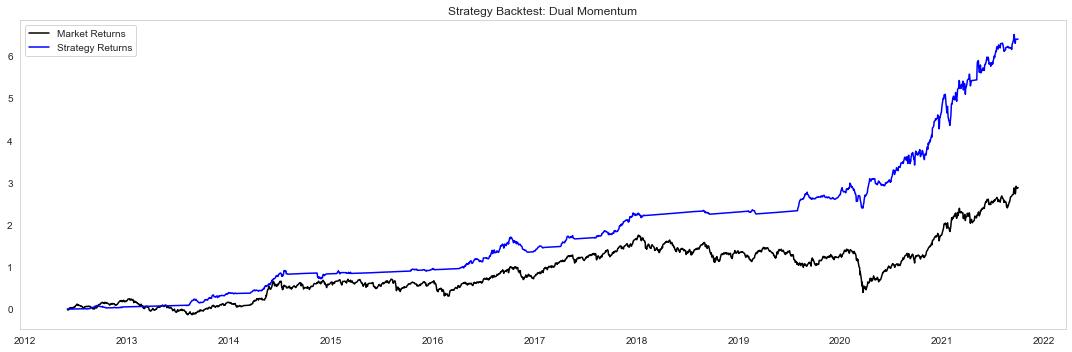

In [22]:
results_final, unit_ticker, unit_gold = backtest_Alpha_AM_Midcap_ConstituentAlphas(dates_rebalancing, data_inp_backtest, assetsb)

bench = yf.download("^NSEMDCP50", start='2007-01-01', end=str(date.today()+timedelta(1)))
bench = bench.loc[bench["Close"] > 1]
bench["Return"] = np.log(bench["Close"] / bench["Close"].shift(1))

results_final["S_Return"] = pd.DataFrame(np.log(results_final["Pvalue"] / results_final["Pvalue"].shift(1)))
temp_res = pd.concat([results_final, bench["Return"]], join="inner", axis=1)
temp_res['Market_Return'] = np.exp(temp_res['Return'].expanding().sum())-1
temp_res['Strategy_Return'] = np.exp(temp_res['S_Return'].expanding().sum())-1
temp_res['Portfolio Value'] = temp_res['Pvalue']
temp_res = temp_res.reset_index().rename(columns={'index': "Date"})

plt.plot(temp_res['Date'], temp_res['Market_Return'], color='black', label='Market Returns')
plt.plot(temp_res['Date'], temp_res['Strategy_Return'], color='blue', label='Strategy Returns')
plt.title('Strategy Backtest: Dual Momentum')
plt.legend(loc=0)
plt.tight_layout()
plt.show()


In [ ]:
results_final.to_csv("Test.csv")

In [ ]:
results_final["Pvalue"].iloc[0]*50000000/results_final["Pvalue"].iloc[-1]

In [ ]:
results_final["Pvalue"]